In [1]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("drsaeedmohsen/ucihar-dataset") + '/UCI-HAR Dataset'
path = '/home/tibless/.cache/kagglehub/datasets/drsaeedmohsen/ucihar-dataset/versions/1/UCI-HAR Dataset'
print("Path to dataset files:", path)

Path to dataset files: /home/tibless/.cache/kagglehub/datasets/drsaeedmohsen/ucihar-dataset/versions/1/UCI-HAR Dataset


In [2]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import random, jit, tree, grad, lax

key = random.PRNGKey(372)

TRAIN_PATH = path + '/train/Inertial Signals/'
TEST_PATH = path + '/test/Inertial Signals/'
PREFIXS = [
    'body_acc_x_',
    'body_acc_y_',
    'body_acc_z_',
    'body_gyro_x_',
    'body_gyro_y_',
    'body_gyro_z_',
    'total_acc_x_',
    'total_acc_y_',
    'total_acc_z_',
]

X_train = []
for prefix in PREFIXS:
    X_train.append(pd.read_csv(TRAIN_PATH + prefix + 'train.txt', header=None, sep=r'\s+').to_numpy())

X_train = np.transpose(np.array(X_train), (1, 0, 2))
X_train = jnp.array(X_train)

X_test = []
for prefix in PREFIXS:
    X_test.append(pd.read_csv(TEST_PATH + prefix + 'test.txt', header=None, sep=r'\s+').to_numpy())
X_test = np.transpose(np.array(X_test), (1, 0, 2))
X_test = jnp.array(X_test)


y_train = jnp.array(pd.read_csv(path + '/train/y_train.txt', header=None).to_numpy().squeeze() - 1)
y_test = jnp.array(pd.read_csv(path + '/test/y_test.txt', header=None).to_numpy().squeeze() - 1)

# 将标签转换为 one-hot 编码
def one_hot(y: jnp.ndarray, num_class: int):
    res = jnp.zeros((y.shape[0], num_class))
    res = res.at[jnp.arange(y.shape[0]), y].set(1)
    return res

y_train = one_hot(y_train, 6)
y_test = one_hot(y_test, 6)

# Suffle
TRAIN = None
TEST = None

shuffle_kernel = random.permutation(key, (X_train.shape[0]))
X_train = X_train[shuffle_kernel][:TRAIN]
y_train = y_train[shuffle_kernel][:TRAIN]
shuffle_kernel = random.permutation(key, (X_test.shape[0]))
X_test = X_test[shuffle_kernel][:TEST]
y_test = y_test[shuffle_kernel][:TEST]

print('X_train 形状:', X_train.shape)  # 应为 (7352, 128, 9)
print('y_train 形状:', y_train.shape)  # 应为 (7352, 6)
print('X_test  形状:', X_test.shape)
print('y_test  形状:', y_test.shape)

X_train 形状: (7352, 9, 128)
y_train 形状: (7352, 6)
X_test  形状: (2947, 9, 128)
y_test  形状: (2947, 6)


In [3]:
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.initer import Initer
from plugins.minitorch.nn import Rnn, Dense
from plugins.minitorch.utils import softmax, cross_entropy_loss, l1_regularization

class lstm_clf:
    def __init__(self, lr=0.01, batch_size=32):
        self.config = {
            'lstm:0': Rnn.get_lstm(128, 9, 64),
            'fc:0': Dense.get_linear(64, 6),
        }

        initer = Initer(self.config, key)
        self.optr = Adam(initer(), lr=lr, batch_size=batch_size)
  
    def predict_proba(self, x: jnp.ndarray, params, train=True):
        '''
        在使用LSTM（长短期记忆网络）进行训练时，是否需要在每个新的epoch开始时更新或重置隐藏状态h0（以及细胞状态c0），主要取决于你的具体应用场景和目标。 
        
        - 序列预测问题：如果你正在处理一个序列预测问题，并且这个序列是连续的，例如时间序列分析或者连续的文本生成，通常你希望保持LSTM的状态跨越批次，以便捕捉长期依赖。在这种情况下，你可能不会在每个epoch开始时重置h0和c0，而是让它们从前一个批次结束时的状态继续传递下去。
        - 独立样本或短序列：然而，如果你的任务涉及独立的样本或者短序列，其中每个样本或序列之间没有直接联系（比如分类任务中每个样本都是独立的），那么在每个新的序列开始之前重置h0和c0为零（或其他初始值）是比较常见的做法。这样做可以避免前一个序列的信息对当前序列产生不必要的影响。
        - Epoch间的考虑：对于大多数应用来说，在每个epoch开始时并不需要特意去改变h0和c0的初始化方式。通常的做法是在每个batch开始之前重置这些状态（如果适用），而不是基于epoch。也就是说，对于每个新的batch，你可能会选择将h0和c0初始化为零向量，尤其是在处理非连续的数据集时。
        '''

        res = jnp.transpose(x, (2, 0, 1))
        res, _, _ = Rnn._lstm_cell(res,
                                  jnp.zeros((res.shape[1], self.config['lstm:0']['hidden_dim'])), 
                                  jnp.zeros((res.shape[1], self.config['lstm:0']['hidden_dim'])), 
                                  params['lstm:0']['Ws'], params['lstm:0']['Us'], params['lstm:0']['Bs'])

        res = res[-1]
        res = res @ params['fc:0']['w'] + params['fc:0']['b']

        return softmax(res)
        
    def fit(self, x_train, y_train_proba, x_test, y_test_proba, epoches=100): 
        cnt = 0

        @jit
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return jnp.mean(y_true == y_pred)

        _loss = lambda params, x, y_true: cross_entropy_loss(y_true, self.predict_proba(x, params, True)) 
        _loss = jit(_loss)  # accelerate loss function by JIT
        self.optr.open(_loss, x_train, y_train_proba)
        
        _tloss = lambda params: cross_entropy_loss(y_test_proba, self.predict_proba(x_test, params, False)) 
        _tloss = jit(_tloss)  # accelerate loss function by JIT
        

        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss

        for _ in range(epoches):
            loss.append(_loss(self.optr.get_params(), x_train, y_train_proba))
            tloss.append(_tloss(self.optr.get_params()))

            self.optr.update()
            
            acc.append(_acc(y_train_proba, self.predict_proba(x_train, self.optr.get_params())))
            tacc.append(_acc(y_test_proba, self.predict_proba(x_test, self.optr.get_params())))
            cnt += 1
            if cnt % 1 == 0:
                print(f'>> epoch: {cnt}, train acc: {acc[-1]}, test acc: {tacc[-1]}')

        return acc, loss, tacc, tloss

In [4]:
epochs = 20
batch_size = 64
lr = 0.01

model = lstm_clf(lr=lr, batch_size=batch_size)
acc, loss, tacc, tloss = model.fit(
    x_train = X_train,
    y_train_proba = y_train,
    x_test = X_test,
    y_test_proba = y_test,
    epoches = epochs,
)

[*] oprimizer opened with 114 batches with batch size 64.
>> epoch: 1, train acc: 0.4783732295036316, test acc: 0.4390906095504761
>> epoch: 2, train acc: 0.6248639822006226, test acc: 0.6073973774909973
>> epoch: 3, train acc: 0.7655059695243835, test acc: 0.7017306089401245
>> epoch: 4, train acc: 0.72048419713974, test acc: 0.6789956092834473
>> epoch: 5, train acc: 0.7963818907737732, test acc: 0.7495758533477783
>> epoch: 6, train acc: 0.8188247680664062, test acc: 0.7665422558784485
>> epoch: 7, train acc: 0.7075625658035278, test acc: 0.6131659150123596
>> epoch: 8, train acc: 0.843035876750946, test acc: 0.7658635973930359
>> epoch: 9, train acc: 0.8744559288024902, test acc: 0.8055649995803833
>> epoch: 10, train acc: 0.8871055245399475, test acc: 0.8439090847969055
>> epoch: 11, train acc: 0.9266865849494934, test acc: 0.8663047552108765
>> epoch: 12, train acc: 0.935799777507782, test acc: 0.8761452436447144
>> epoch: 13, train acc: 0.9385201334953308, test acc: 0.8819138407

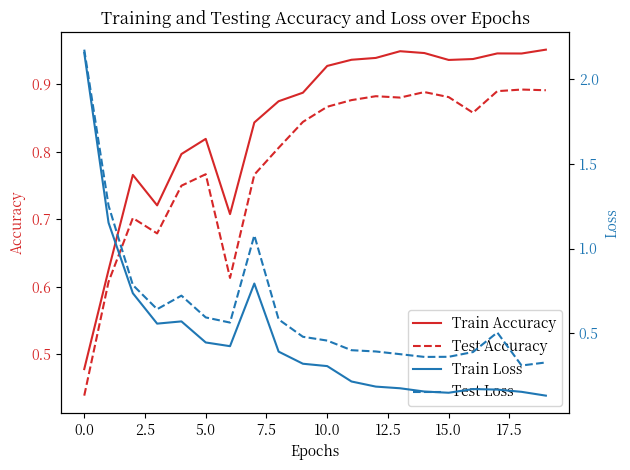

final train, test acc : 0.9507616758346558, 0.8907363414764404
final train, test loss: 0.13009272515773773, 0.3263832926750183


In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
# plt.savefig('./assets/lstm.png')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')
